# Sean Xander B. Aquino BSCS 2A

# Importing Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## Load the Dataset

In [14]:
abalone = fetch_ucirepo(id=1)

# Extract features and target
X = abalone.data.features
y = abalone.data.targets


## Combine into a single DataFrame for exploration

In [15]:

df = pd.concat([X, y], axis=1)
print("Columns in the dataset:\n", df.columns)
print("\nFirst few rows of the dataset:\n", df.head())

Columns in the dataset:
 Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight', 'Rings'],
      dtype='object')

First few rows of the dataset:
   Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  


## Categorize "Rings"(Regression) into "Age Groups"(Classification)

In [16]:
df['Age Group'] = pd.cut(df['Rings'], bins=[0, 5, 10, 30], labels=['Young', 'Adult', 'Old'])
print("\nModified dataset with Age Group:\n", df.head())
print("\nAge Group Distribution:\n", df['Age Group'].value_counts())


Modified dataset with Age Group:
   Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings Age Group  
0         0.150     15       Old  
1         0.070      7     Adult  
2         0.210      9     Adult  
3         0.155     10     Adult  
4         0.055      7     Adult  

Age Group Distribution:
 Age Group
Adult    2541
Old      1447
Young     189
Name: count, dtype: int64


## Visualize the relationships between each features

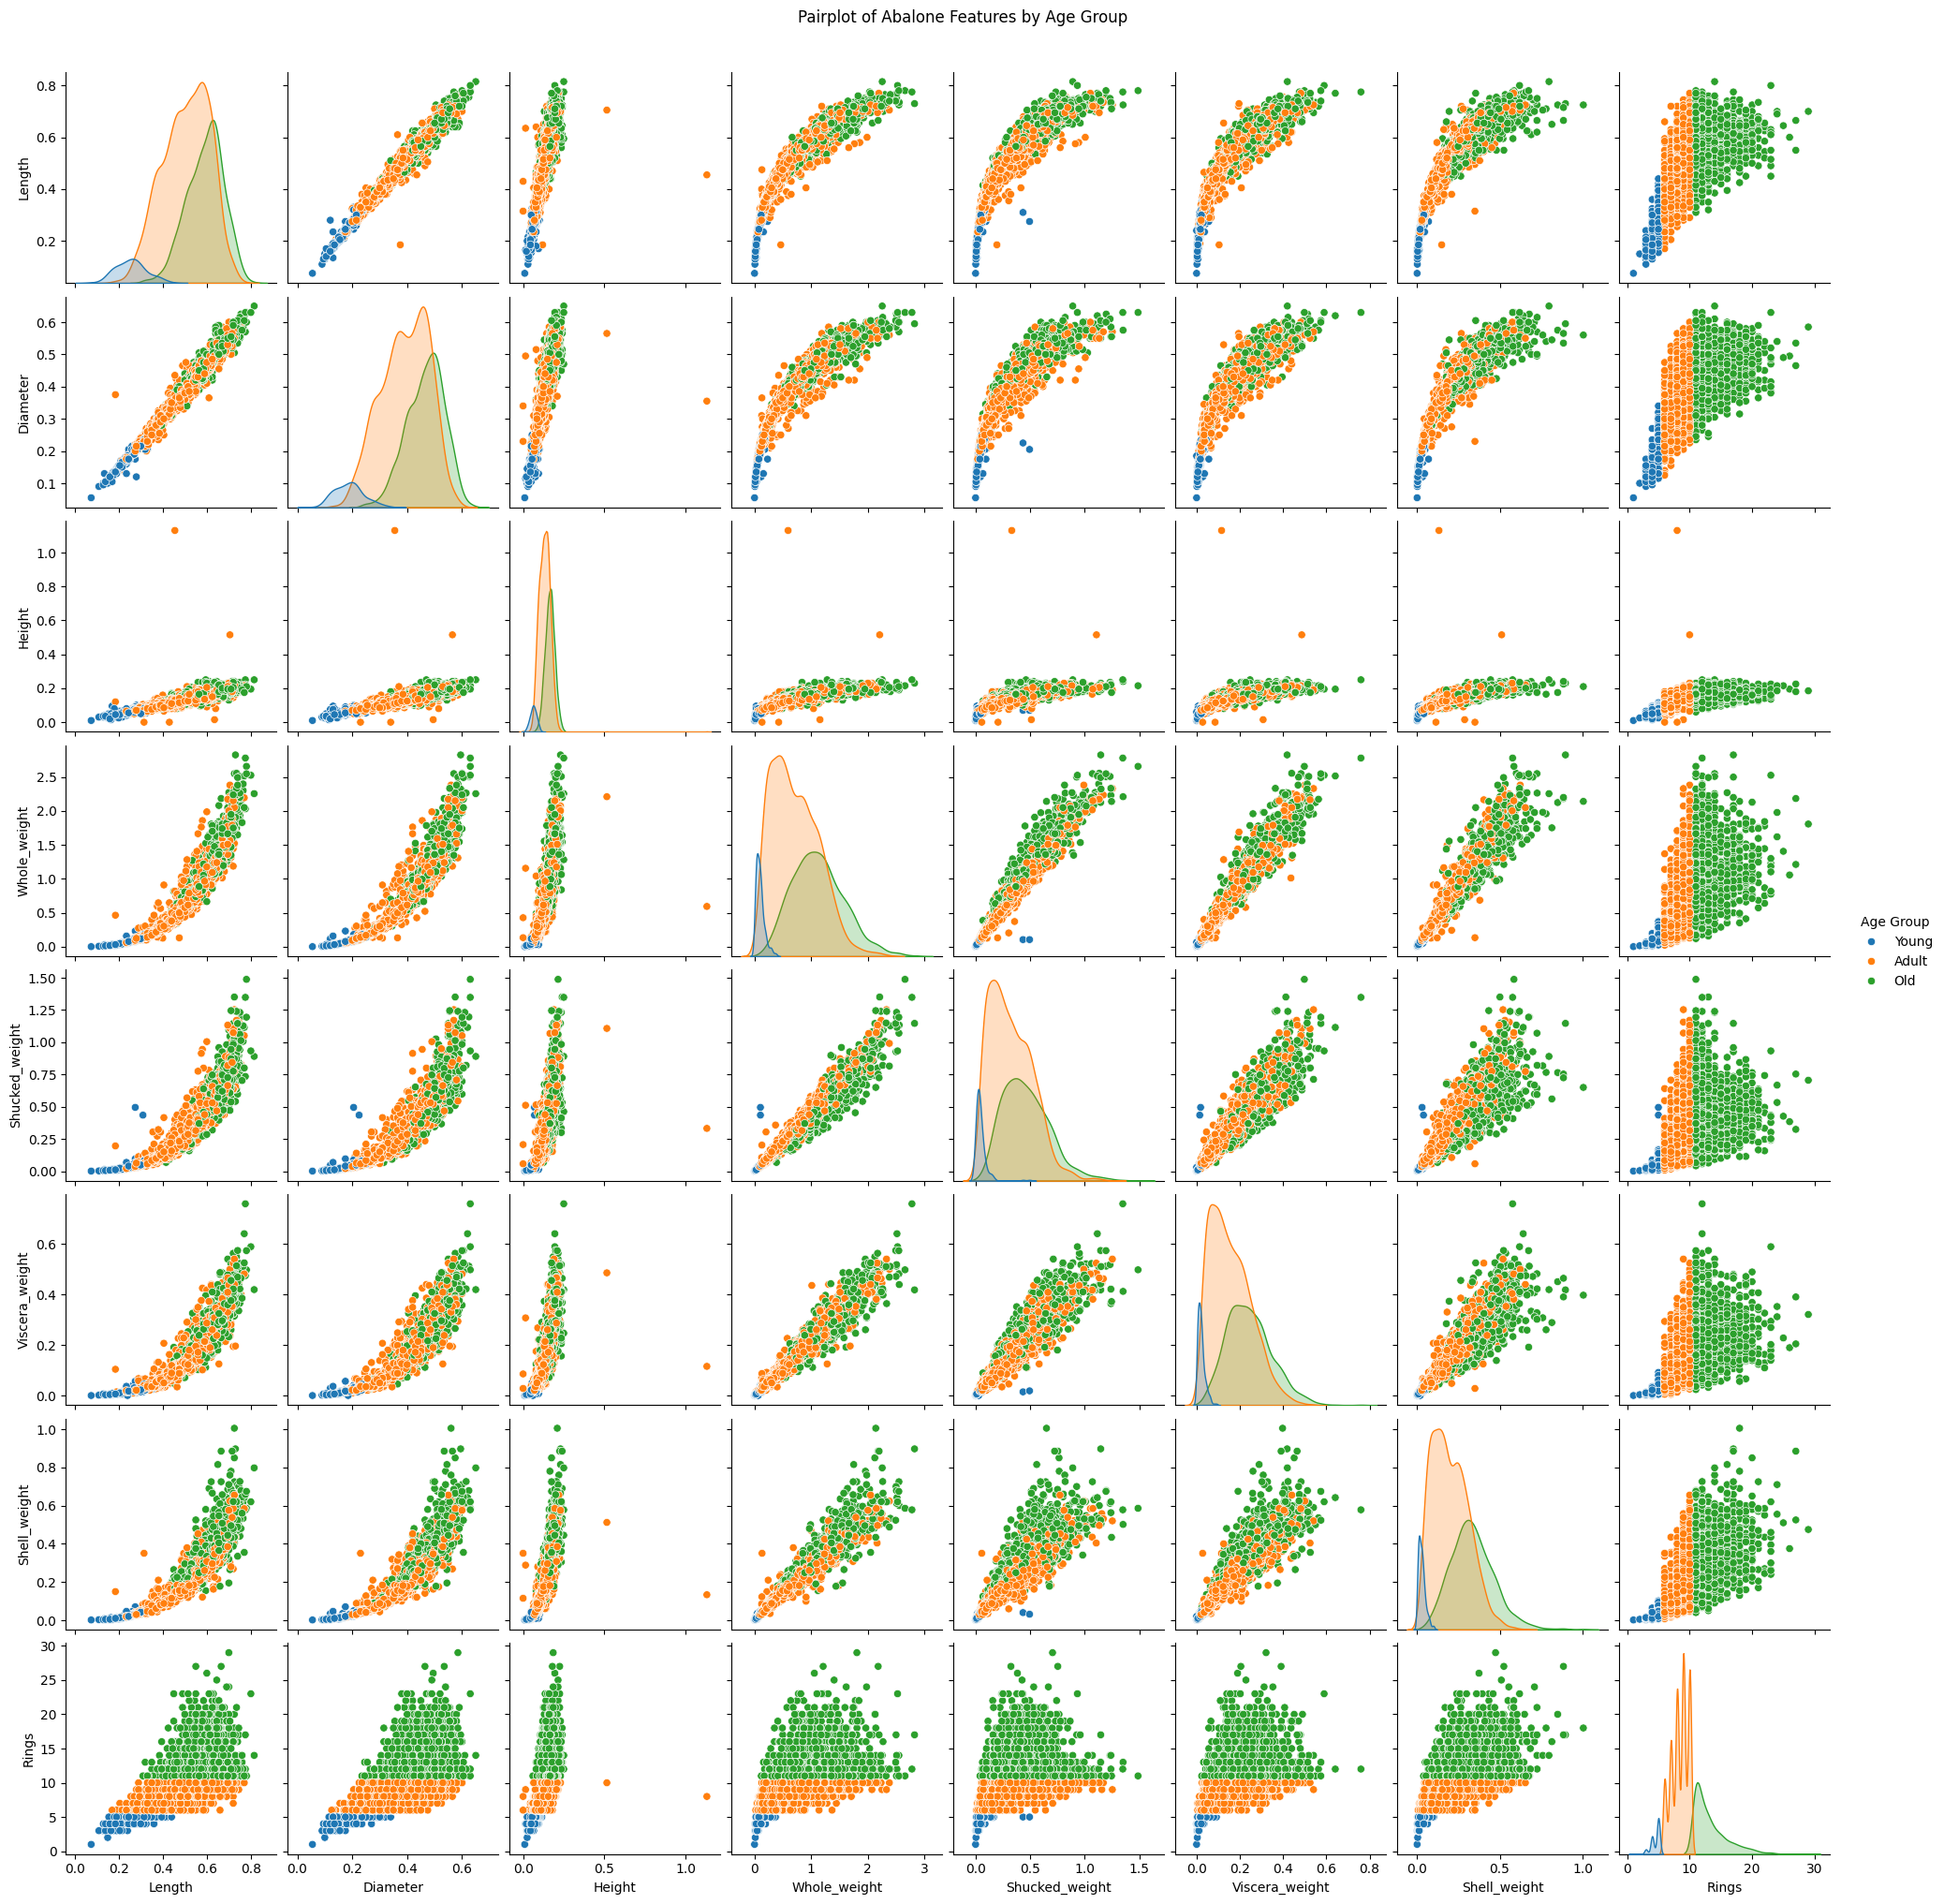

In [17]:
sns.pairplot(df, hue='Age Group')
plt.suptitle("Pairplot of Abalone Features by Age Group", y=1.02)
plt.show()

### Convert categorical data (Sex) to numeric


In [18]:
df['Sex'] = df['Sex'].map({'M': 0, 'F': 1, 'I': 2})  # Convert 'M', 'F', 'I' to numeric values

# Data Preparation

In [19]:
# Prepare Data for SVM
X = df.drop(columns=['Age Group', 'Rings'])  # Drop 'Age Group' and 'Rings' from features
y = df['Age Group']  # Target is now 'Age Group'

## Split Dataset into Training and Testing Sets

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale features for Support Vector Machine
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Analysis of different values of C on the accuracy of the model

In [21]:
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
mean_acc = []

for c in C_values:
    svm_model = SVC(C=c, kernel='rbf', gamma='scale')  # Using RBF kernel and fixed gamma for fair comparison
    scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=5)
    mean_acc.append(scores.mean())
    print(f"C={c} | Cross-Val Accuracy: {scores.mean():.4f}")

C=0.001 | Cross-Val Accuracy: 0.6030
C=0.01 | Cross-Val Accuracy: 0.6261
C=0.1 | Cross-Val Accuracy: 0.7306
C=1 | Cross-Val Accuracy: 0.7658
C=10 | Cross-Val Accuracy: 0.7658
C=100 | Cross-Val Accuracy: 0.7606
C=1000 | Cross-Val Accuracy: 0.7482


### Visualization of C Regularization VS Accuracy

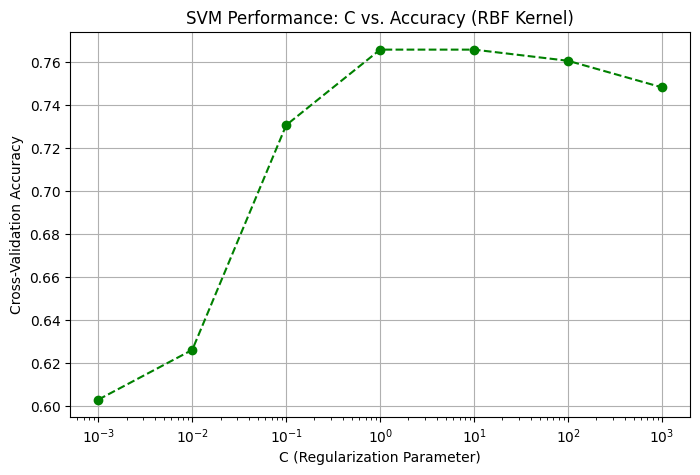

In [22]:
plt.figure(figsize=(8, 5))
plt.plot(C_values, mean_acc, marker='o', linestyle='--', color='green')
plt.xscale('log')
plt.xlabel("C (Regularization Parameter)")
plt.ylabel("Cross-Validation Accuracy")
plt.title("SVM Performance: C vs. Accuracy (RBF Kernel)")
plt.grid(True)
plt.show()

# Final Model Training with Hyperparameters with Grid Search

In [23]:
param_grid = {
    'C': [0.01, 0.1, 1, 10],        
    'gamma': ['scale', 'auto', 0.1, 1, 10],
    'kernel': ['rbf'], #['rbf', 'sigmoid', 'poly'], (other choices but takes too much time)
    'shrinking': [True, False],           
    'probability': [True, False],         
    'tol': [1e-3, 1e-4],                
}

# Perform Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(SVC(), param_grid, refit=True, verbose=3, cv=5, n_jobs=-1)  # Use all processors
grid_search.fit(X_train_scaled, y_train)

# Best parameters found by GridSearchCV
print("\nBest Hyperparameters from Grid Search:\n", grid_search.best_params_)


Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best Hyperparameters from Grid Search:
 {'C': 10, 'gamma': 'auto', 'kernel': 'rbf', 'probability': True, 'shrinking': True, 'tol': 0.001}


## Prediction and evaluating the final model

In [24]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled) # Make predictions on the test set

# Display Evaluation Metrics

In [25]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

       Adult       0.79      0.83      0.81      1030
         Old       0.69      0.67      0.68       554
       Young       0.79      0.51      0.62        87

    accuracy                           0.76      1671
   macro avg       0.76      0.67      0.70      1671
weighted avg       0.76      0.76      0.76      1671



# Plotting of Confusion Matrix

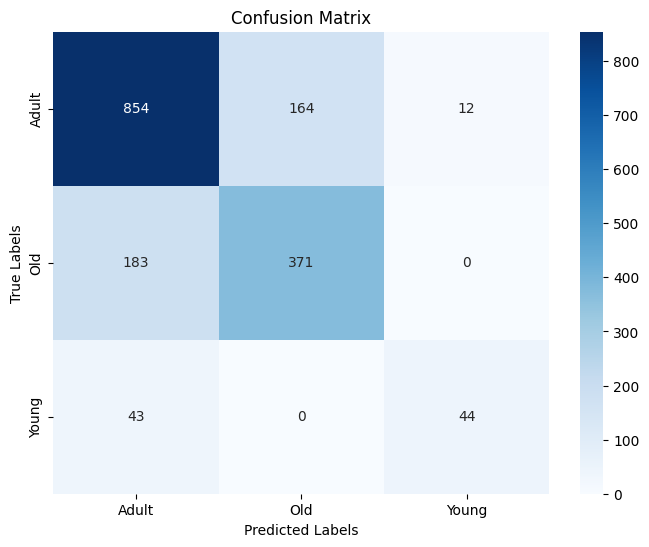

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Final Accuracy

In [27]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.0f}%")


Accuracy: 76%
